We going to build a model which identify lung disese by viewing the chest x-ray

In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split

In [7]:
# Paths to the dataset folders
dataset_paths = {
    "COVID-19": r"D:\Dataset\Chest X_Ray Dataset\COVID19",
    "NORMAL": r"D:\Dataset\Chest X_Ray Dataset\NORMAL",
    "PNEUMONIA": r"D:\Dataset\Chest X_Ray Dataset\PNEUMONIA",
    "TUBERCULOSIS": r"D:\Dataset\Chest X_Ray Dataset\TURBERCULOSIS"
}

# Count images in each class
class_counts = {class_name: len(os.listdir(path)) for class_name, path in dataset_paths.items()}
total_images = sum(class_counts.values())

# Calculate percentages
class_percentages = {class_name: (count / total_images) * 100 for class_name, count in class_counts.items()}

Class Counts: {'COVID-19': 573, 'NORMAL': 1583, 'PNEUMONIA': 4273, 'TUBERCULOSIS': 700}
Class Percentages: {'COVID-19': 8.037592930284752, 'NORMAL': 22.205077851031, 'PNEUMONIA': 59.9382802637116, 'TUBERCULOSIS': 9.819048954972647}


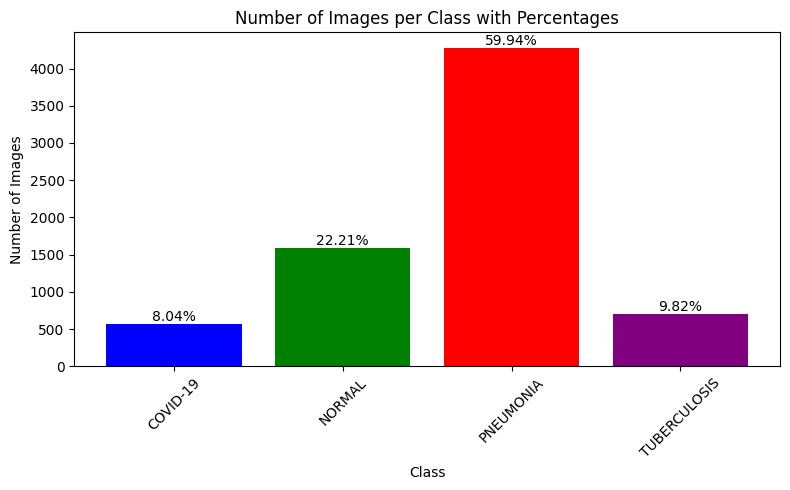

In [8]:
# Display results
print("Class Counts:", class_counts)
print("Class Percentages:", class_percentages)

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'green', 'red', 'purple'])
for i, (count, percentage) in enumerate(zip(class_counts.values(), class_percentages.values())):
    plt.text(i, count, f"{percentage:.2f}%", ha='center', va='bottom')

plt.title("Number of Images per Class with Percentages")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Labels for each class
class_labels = {
    "COVID-19": 1,
    "NORMAL": 0,
    "PNEUMONIA": 2,
    "TUBERCULOSIS": 3
}

# Target number of images per class
target_count = 573

# Variables to store images and labels
dataset = []
labels = []

In [10]:
# Function to load random samples from each class
def load_random_samples(path, label, count):
    all_images = os.listdir(path)
    selected_images = random.sample(all_images, count)  # Randomly sample images
    images = []
    for img_name in selected_images:
        img_path = os.path.join(path, img_name)
        # Load and preprocess the image (resizing to a fixed size, e.g., 224x224)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Use grayscale for X-rays
        img = cv2.resize(img, (224, 224))  # Resize to 224x224
        images.append(img)
    return images, [label] * count

In [18]:
# Loop through each class and load images
for class_name, path in dataset_paths.items():
    images, class_labels_list = load_random_samples(path, class_labels[class_name], target_count)
    dataset.extend(images)
    labels.extend(class_labels_list)

# Convert dataset and labels to NumPy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Shuffle the dataset
indices = np.arange(len(dataset))
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]

In [19]:
# Output shapes and counts for verification
print("Dataset shape:", dataset.shape)
print("Labels shape:", labels.shape)
print("Label distribution:", {label: np.sum(labels == label) for label in np.unique(labels)})

Dataset shape: (2292, 224, 224)
Labels shape: (2292,)
Label distribution: {np.int64(0): np.int64(573), np.int64(1): np.int64(573), np.int64(2): np.int64(573), np.int64(3): np.int64(573)}


In [21]:
dataset[5]

array([[ 34,  35,  32, ..., 181, 189, 156],
       [ 35,  35,  35, ..., 184, 189, 156],
       [ 37,  38,  38, ..., 186, 191, 159],
       ...,
       [ 51,  63,  74, ...,  32,  32,  32],
       [ 51,  62,  76, ...,  32,  32,  32],
       [ 46,  58,  70, ...,  32,  32,  32]], dtype=uint8)

Our dataset is not scaled between 0 and 1 so we have to scale it

In [22]:
print("Min pixel value:", dataset.min())
print("Max pixel value:", dataset.max())

Min pixel value: 0
Max pixel value: 255


In [23]:
# Normalize the dataset by dividing by 255.0
dataset = dataset.astype('float32') / 255.0

# Verify the range of values in the dataset
print("Min pixel value:", dataset.min())
print("Max pixel value:", dataset.max())

Min pixel value: 0.0
Max pixel value: 1.0


In [28]:
# Function to split data while maintaining class balance
def stratified_split(dataset, labels, train_ratio=0.8):
    # Separate dataset and labels by class
    class_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}
    train_indices, test_indices = [], []
    
    for label, indices in class_indices.items():
        np.random.shuffle(indices)  # Shuffle indices for randomness
        split_point = int(len(indices) * train_ratio)
        train_indices.extend(indices[:split_point])  # Add to training set
        test_indices.extend(indices[split_point:])  # Add to testing set
    
    # Create training and testing sets
    train_dataset = dataset[train_indices]
    train_labels = labels[train_indices]
    test_dataset = dataset[test_indices]
    test_labels = labels[test_indices]
    
    return train_dataset, train_labels, test_dataset, test_labels

# Perform the stratified split
train_dataset, train_labels, test_dataset, test_labels = stratified_split(dataset, labels, train_ratio=0.8)

# Output shapes and counts for verification
print("Training dataset shape:", train_dataset.shape)
print("Training labels shape:", train_labels.shape)
print("Training label distribution:", {label: np.sum(train_labels == label) for label in np.unique(train_labels)})

print("Testing dataset shape:", test_dataset.shape)
print("Testing labels shape:", test_labels.shape)
print("Testing label distribution:", {label: np.sum(test_labels == label) for label in np.unique(test_labels)})

Training dataset shape: (1832, 224, 224)
Training labels shape: (1832,)
Training label distribution: {np.int64(0): np.int64(458), np.int64(1): np.int64(458), np.int64(2): np.int64(458), np.int64(3): np.int64(458)}
Testing dataset shape: (460, 224, 224)
Testing labels shape: (460,)
Testing label distribution: {np.int64(0): np.int64(115), np.int64(1): np.int64(115), np.int64(2): np.int64(115), np.int64(3): np.int64(115)}


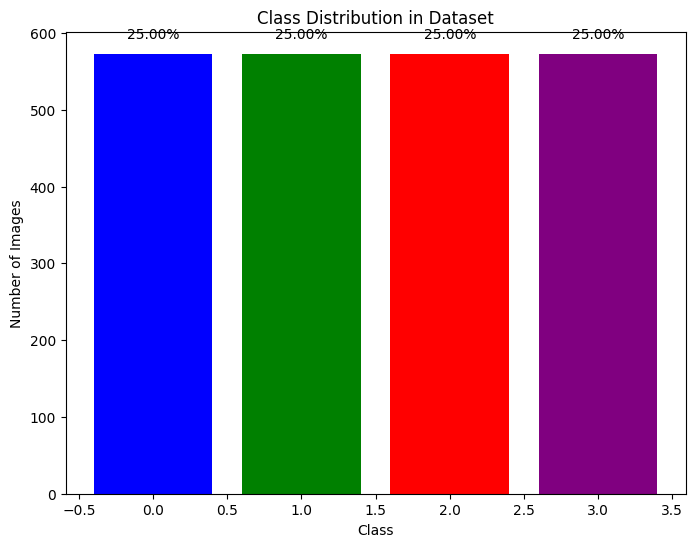

In [29]:
# Count the number of samples per class
class_counts = {label: np.sum(labels == label) for label in np.unique(labels)}

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'green', 'red', 'purple'])

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')

# Display the percentage for each class
total_samples = len(labels)
for i, (label, count) in enumerate(class_counts.items()):
    percentage = (count / total_samples) * 100
    plt.text(i, count + 20, f'{percentage:.2f}%', ha='center')

# Show the plot
plt.show()

In training set we have equal number of images per class

Now here we are saving the tensors in numpy .npz file and upload it on drive so we train the model on google colab

In [30]:
# Define the path where you want to save the .npz file
npz_file_path = r"D:\Dataset\Chest X_Ray Dataset\npz file (tensors)\chest_xray_split_dataset.npz"

# Save the train and test datasets and labels in the .npz file
np.savez(npz_file_path, 
         train_dataset=train_dataset, 
         train_labels=train_labels, 
         test_dataset=test_dataset, 
         test_labels=test_labels)

# Verify the file is saved
print(f"Training and testing datasets saved to {npz_file_path}")

Training and testing datasets saved to D:\Dataset\Chest X_Ray Dataset\npz file (tensors)\chest_xray_split_dataset.npz
